In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Function definitions

In [250]:
sns.set_theme('paper')
def plot_results(lift,group_a_mean,group_b_mean,p_value,title):
    """ This function plots the results of the hypothesis test"""
    
    ax = sns.barplot(x=['Control','Treatment'],
                  y=[group_a_mean, group_b_mean],
                  hue=['Control','Treatment'],
                  width=0.8,
                  gap=0.1
                  )
    # add mean values
    ax.bar_label(ax.containers[0], fontsize=9);
    ax.bar_label(ax.containers[1], fontsize=9);
    # add p_value label
    p_value_label = "p_value= "+ str(round(p_value,3))
    p_value_color = 'darkgreen' if p_value<=0.05 else 'darkred'
    ax.text(x=1,y=8, s=p_value_label, color= p_value_color, fontsize=11,ha='center')
    # add relative lift label
    lift_label = "lift: "+str(round(lift*100,2))+"%"
    ax.text(x=1,y=9, s=lift_label, fontsize=11,ha='center')
    # set titles
    ax.set_title(title)
    ax.set_ylabel('Mean Revenue ($)')
    return ax

### Import data
First we read the dataset.

In [235]:
df_raw = pd.read_csv("data.csv")
df_raw.head()

,user_id,set_group_dt,group,item,has_gold,price,purchase_date,platform
0,usr_1,2024-06-20 1:29:18,0,timed_6_1,0,0.99,9/1/2024,Android
1,usr_2,2024-07-04 13:30:14,0,gem_sub_1,0,2.99,9/1/2024,Android
2,usr_3,2024-08-13 11:16:08,1,timed_6_1,0,0.99,9/1/2024,Android
3,usr_4,2024-08-05 13:38:11,1,timed_6_1,0,0.99,9/1/2024,Android
4,usr_5,2024-08-13 16:43:28,0,prog_a_100_1,0,39.99,9/1/2024,Android


Data dictionary:

|Column|Description|
|----|----|
|user_pseudo_id|Id to identify the user|
|group|0: Control group, 1: Tratment group|
|item|Offer purchased by the user|
|Set_group_DT|Datetime when the user was assigned to the group|
|Date|Date of the purchese|
|platform|Android/iOS|
|price|Item's sale price|
|has_gold|wheter the item contains Gold currency. 0: it doesn't contain, 1: it contains gold|

### Data preparation
In order to know the impact of the new gold subcription, two hypothesis tests need to be evaluated.
The first test to run is the impact of the new gold subcription in "other" existing offers sales.

The second test is to evaluate if the new gold subscription did some impact on the overall revenue.

Before proceeding with the hypothesis tests, the data needs to be transformed as follows:
1. identify the rows with `gold_sub` and ``gold_resub`` transactions
2. Add two columns `gold_sub_rev` to identify the revenue generated by the new gold subscription.
3. Add a new column `other_rev` to identify the revenue generated by the standard 'old' offers.

In [60]:
df = df_raw.copy()
df['is_gold_sub'] = df['item'].isin(['gold_sub','gold_resub'])
df['gold_sub_rev'] = df.apply(lambda x: x.price if x.is_gold_sub else 0, axis=1 )
df['other_rev'] = df.apply(lambda x: x.price if not x.is_gold_sub else 0, axis=1 )
df.head()

,user_id,set_group_dt,group,item,has_gold,price,purchase_date,platform,is_gold_sub,gold_sub_rev,other_rev
0,usr_1,2024-06-20 1:29:18,0,timed_6_1,0,0.99,9/1/2024,Android,False,0.0,0.99
1,usr_2,2024-07-04 13:30:14,0,gem_sub_1,0,2.99,9/1/2024,Android,False,0.0,2.99
2,usr_3,2024-08-13 11:16:08,1,timed_6_1,0,0.99,9/1/2024,Android,False,0.0,0.99
3,usr_4,2024-08-05 13:38:11,1,timed_6_1,0,0.99,9/1/2024,Android,False,0.0,0.99
4,usr_5,2024-08-13 16:43:28,0,prog_a_100_1,0,39.99,9/1/2024,Android,False,0.0,39.99


With these new columns added, a new dataframe can be created grouped by user and test group. The new dataframe will have all the revenues per user.

In [92]:
df_user = df.groupby(by=['user_id','group','platform'])[['other_rev','gold_sub_rev','price']].sum().reset_index().sort_values(by='price',ascending=False)
# rename the 'price' column to describe better the aggregation
df_user = df_user.rename({'price':'total_rev'},axis=1)

df_user

,user_id,group,platform,other_rev,gold_sub_rev,total_rev
22,usr_119,1,iOS,1493.51,31.97,1525.48
610,usr_80,1,iOS,748.86,31.97,780.83
492,usr_541,1,iOS,778.62,0.00,778.62
520,usr_567,0,iOS,679.66,0.00,679.66
4,usr_102,0,iOS,538.69,0.00,538.69
...,...,...,...,...,...,...
239,usr_313,0,iOS,0.99,0.00,0.99
289,usr_359,0,Android,0.99,0.00,0.99
269,usr_340,0,Android,0.99,0.00,0.99
279,usr_35,1,Android,0.99,0.00,0.99


Plot a Histogram of the total_revenue:

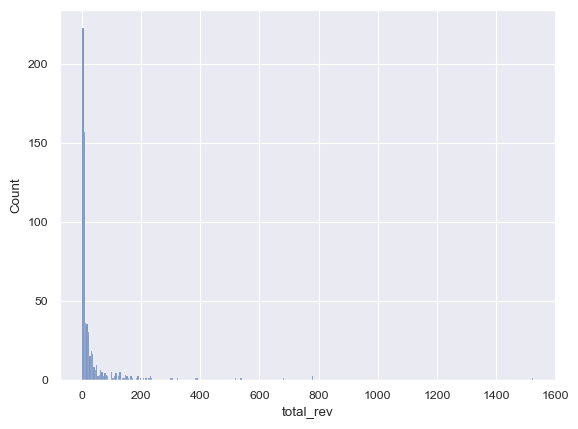

In [139]:
ax = sns.histplot(data=df_user,x='total_rev')

As expected, total revenue data is "heavy-tailed", because most users spend $0 or small amounts, while a few users spend a lot. This means the data doesn't follow a normal distribution.

High spenders add a lot of variance and can mask the impact of the new subscription. The 10% of outlier users with high spending are going to be remove to avoid this.

In [66]:
limit=df_user.total_rev.quantile(0.90) 
df_user_red = df_user[df_user.total_rev <=limit]
df_user_red

,user_id,group,other_rev,gold_sub_rev,total_rev
526,usr_572,0,69.96,0.00,69.96
435,usr_490,1,69.95,0.00,69.95
35,usr_130,1,26.94,41.96,68.90
231,usr_306,1,35.95,31.97,67.92
16,usr_113,0,64.98,0.00,64.98
...,...,...,...,...,...
239,usr_313,0,0.99,0.00,0.99
289,usr_359,0,0.99,0.00,0.99
269,usr_340,0,0.99,0.00,0.99
279,usr_35,1,0.99,0.00,0.99


Given that the data doesn't follow a normal distribution, the type of test selected is the **Mann-Whitney U** Test

## Test 1
First test to run is to evaluate the impact of the new gold_sub offer on the other offers.

- $H_0$: The ``gold_sub`` has no impact on revenue from existing items.
- $H_1$: The ``gold_sub`` significantly impacts revenue from existing items.

In [236]:
group_a_other = df_user_red[df_user_red.group==0]['other_rev']
group_b_other = df_user_red[df_user_red.group==1]['other_rev']
res_other = stats.mannwhitneyu(group_a_other, group_b_other, alternative='two-sided')
print(res_other)


MannwhitneyuResult(statistic=np.float64(44131.5), pvalue=np.float64(0.038812380703638995))


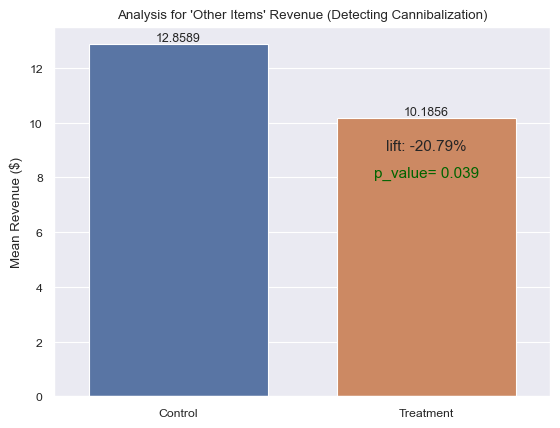

In [251]:
relative_lift_other = (group_b_other.mean()-group_a_other.mean())/group_a_other.mean()
ax1=plot_results(relative_lift_other,
             group_a_other.mean(),
             group_b_other.mean(),
             res_other.pvalue,
             "Analysis for 'Other Items' Revenue (Detecting Cannibalization)"
             )


The mean revenue in the treatment group is 20.79% lower than the control group. This means the users are spending a fith less on the other items in the treatment group.

The p-value is 3.88%, it is lower than 5%, which indicates that the null hypothesis can be rejected. It can be concluded that the new `gold_sub` offers are 'canibalising' the other items revenue, this means that users are spending less in the other items and more in the gold subscription.

**Decision:** Reject $H_0$. The data shows a significant decrease in existing item sales.

## Test 2
The second test evaluates if the introduction of the new subscription increases the total revenue.
- $H_0$: The ``gold_sub`` has no impact on total app revenue.
- $H_1$: The ``gold_sub`` significantly changes total app revenue.

In [252]:
group_a_total = df_user_red[df_user_red.group==0]['total_rev']
group_b_total = df_user_red[df_user_red.group==1]['total_rev']
res_total = stats.mannwhitneyu(group_a_total, group_b_total, alternative='two-sided')
print(res_total)


MannwhitneyuResult(statistic=np.float64(40848.0), pvalue=np.float64(0.7232687039599919))


<Axes: title={'center': "Analysis for 'Total' Revenue (Detecting Incrementality)"}, ylabel='Mean Revenue ($)'>

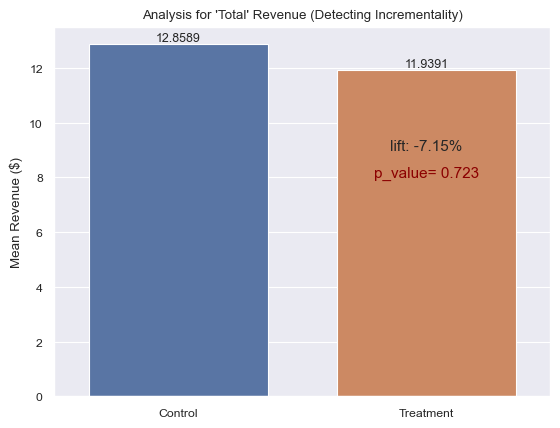

In [253]:
relative_lift_total = (group_b_total.mean()-group_a_total.mean())/group_a_total.mean()
plot_results(relative_lift_total,
             group_a_total.mean(),
             group_b_total.mean(),
             res_total.pvalue,
             "Analysis for 'Total' Revenue (Detecting Incrementality)"
             )

In this case, both groups are too close (only with a 7.25% difference) with a p-value of 0.72 which is very high and fails to reject the null hypothesis. This means that the 7% drop in revenue is due to random noise and the total revenue hasn't been affected by the introduction of the new subscription.

**Decision:** Fail to Reject $H_0$. There is no evidence that the subscription increased the total app revenue.

## Conclusions
1. The gold_sub is a direct substitute for existing items.
2. The 20.8% drop in revenue from existing items is compensated byt he gold subscription revenue.
3. The impact of the gold subscription on the total revenue is neutral.

## Recomendation
The gold subscription could improve Retention and LTV (Life Time Value) in the long term that could justify thee loss of existing items revenue..

## Next steps
Evaluate the impaact of the gold subscription on both platforms. Subscriptions perform generally better on iOS. If one platform perform better than the other, there is the possibility to enable the gold subscription in only one platfrom.